In [1]:
import numpy as np
import pandas as pd
from typing import Mapping, List, Tuple
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
    load_breast_cancer, load_diabetes, fetch_mldata
from  matplotlib.collections import LineCollection
import time
from pandas.api.types import is_string_dtype, is_object_dtype, is_categorical_dtype, is_bool_dtype
from sklearn.ensemble.partial_dependence import partial_dependence, plot_partial_dependence
from pdpbox import pdp
from rfpimp import *
from scipy.integrate import cumtrapz
from mine.plot import *
from mine.ice import *

# Auto-MPG

In [2]:
def lm_plot(X, y, colname, targetname,ax=None):
    r_col = LinearRegression()
    r_col.fit(X[[colname]], y)
    ax.scatter(X[colname], y, alpha=.12)
    ax.set_xlabel(colname)
    ax.set_ylabel(targetname)
    ax.set_title(targetname+" vs "+colname)
    col = X[colname]
    y_pred_hp = r_col.predict(col.values.reshape(-1, 1))
    ax.plot(col, y_pred_hp, ":", linewidth=1, c='red', label='OLS y ~ horsepower')
    r = LinearRegression()
    r.fit(X, y)
    xcol = np.linspace(np.min(col), np.max(col), num=100)
    ci = X.columns.get_loc(colname)
    ax.plot(xcol, xcol * r.coef_[ci] + r_col.intercept_, linewidth=1, c='orange', label="Beta_horsepower")
    left30 = xcol[int(len(xcol) * .3)]
    ax.text(left30, left30*r.coef_[ci] + r_col.intercept_, f"slope={r.coef_[ci]:.3f}")
    ax.legend()

In [8]:
df_cars = pd.read_csv("data/auto-mpg.csv")
df_cars = df_cars[df_cars['horsepower']!='?'] # drop the few missing values
df_cars['horsepower'] = df_cars['horsepower'].astype(float)
df_cars.head(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino


collect_leaf_slopes 2.287s
collect_leaf_slopes 1.131s
ICE_predict 0.074s
ICE_predict 0.224s


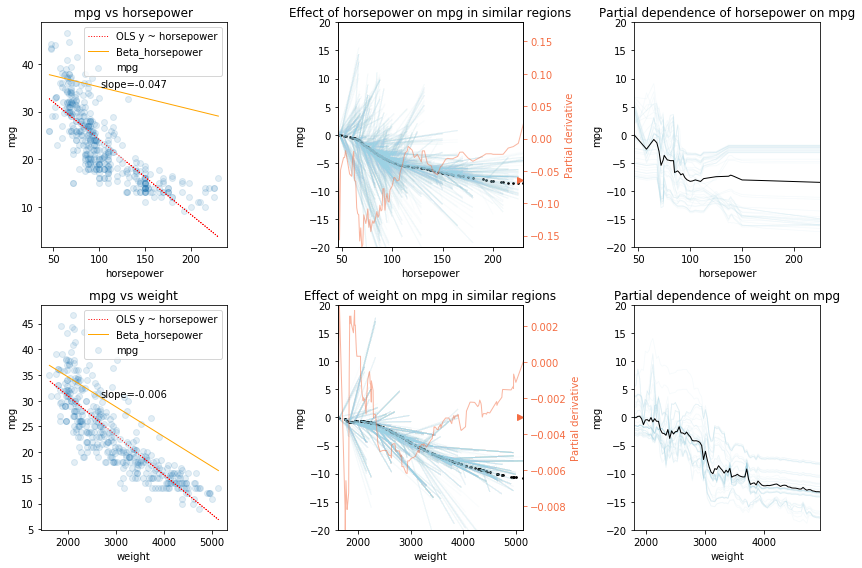

In [9]:
X = df_cars[['horsepower', 'weight']]
y = df_cars['mpg']

fig, axes = plt.subplots(2, 3, figsize=(12,8))
lm_plot(X, y, 'horsepower', 'mpg', ax=axes[0,0])
mine_plot(X, y, 'horsepower', 'mpg', ax=axes[0,1], show_derivative=True, yrange=(-20,20), hires_threshold=30)

lm_plot(X, y, 'weight', 'mpg', ax=axes[1,0])
mine_plot(X, y, 'weight', 'mpg', ax=axes[1,1], show_derivative=True, yrange=(-20,20), hires_threshold=30)

rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)
ice = ice_predict(rf, X, 'horsepower', 'mpg', nlines=50, numx=None)
ice_plot(ice, 'horsepower', 'mpg', ax=axes[0, 2], yrange=(-20,20))
ice = ice_predict(rf, X, 'weight', 'mpg', nlines=50, numx=100)
ice_plot(ice, 'weight', 'mpg', ax=axes[1, 2], yrange=(-20,20))

plt.tight_layout()

plt.show()

# NYC apt rent

## Download, prep data

*Data use rules prevent me from storing this data in this repo*. Download the data set from Kaggle. (You must be a registered Kaggle user and must be logged in.) Go to the Kaggle [data page](https://www.kaggle.com/c/two-sigma-connect-rental-listing-inquiries/data) and save `train.json` into the `data` directory underneath this notebook.

In [7]:
df = pd.read_json('data/train.json')

# Create ideal numeric data set w/o outliers etc...
df = df[(df.price>1_000) & (df.price<10_000)]
df = df[(df.longitude!=0) | (df.latitude!=0)]
df = df[(df['latitude']>40.55) & (df['latitude']<40.94) &
        (df['longitude']>-74.1) & (df['longitude']<-73.67)]
df_rent = df[['bedrooms','bathrooms','latitude','longitude','price']]
df_rent.head()

,bedrooms,bathrooms,latitude,longitude,price
10,3,1.5,40.7145,-73.9425,3000
10000,2,1.0,40.7947,-73.9667,5465
100004,1,1.0,40.7388,-74.0018,2850
100007,1,1.0,40.7539,-73.9677,3275
100013,4,1.0,40.8241,-73.9493,3350


collect_leaf_slopes 9.886s
collect_leaf_slopes 8.158s
collect_leaf_slopes 10.443s
collect_leaf_slopes 10.324s
ICE_predict 0.946s
ICE_predict 0.823s
ICE_predict 0.831s
ICE_predict 0.723s


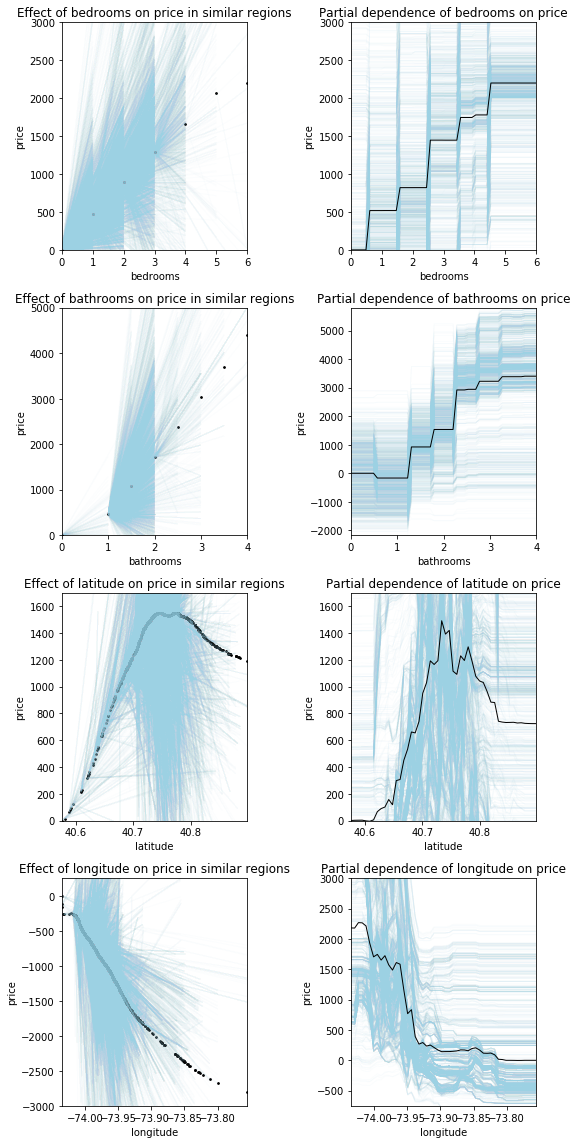

In [10]:
df_rent = df_rent.sample(n=2000)  # get a small subsample
X = df_rent.drop('price', axis=1)
y = df_rent['price']

fig, axes = plt.subplots(4, 2, figsize=(8,16))
mine_plot(X, y, 'bedrooms', 'price', ax=axes[0,0], alpha=.03, yrange=(0,3000))
mine_plot(X, y, 'bathrooms', 'price', ax=axes[1,0], alpha=.03, yrange=(0,5000))
mine_plot(X, y, 'latitude', 'price', ax=axes[2,0], alpha=.03, yrange=(0,1700))
mine_plot(X, y, 'longitude', 'price', ax=axes[3,0], alpha=.03, yrange=(-3000,250))

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)

# rf = Lasso()
# rf.fit(X, y)

ice = ice_predict(rf, X, 'bedrooms', 'price')
ice_plot(ice, 'bedrooms', 'price', ax=axes[0, 1], alpha=.05, yrange=(0,3000))
ice = ice_predict(rf, X, 'bathrooms', 'price')
ice_plot(ice, 'bathrooms', 'price', alpha=.05, ax=axes[1, 1])
ice = ice_predict(rf, X, 'latitude', 'price')
ice_plot(ice, 'latitude', 'price', ax=axes[2, 1], alpha=.05, yrange=(0,1700))
ice = ice_predict(rf, X, 'longitude', 'price')
ice_plot(ice, 'longitude', 'price', ax=axes[3, 1], alpha=.05, yrange=(-750,3000))

plt.tight_layout()
plt.show()

# Synthetic human weight data

In [11]:
def toy_weight_data(n):
    df = pd.DataFrame()
    nmen = n//2
    nwomen = n//2
    df['ID'] = range(100,100+n)
    df['sex'] = ['M']*nmen + ['F']*nwomen
    df.loc[df['sex']=='F','pregnant'] = np.random.randint(0,2,size=(nwomen,))
    df.loc[df['sex']=='M','pregnant'] = 0
    df.loc[df['sex']=='M','height'] = 5*12+8 + np.random.uniform(-7, +8, size=(nmen,))
    df.loc[df['sex']=='F','height'] = 5*12+5 + np.random.uniform(-4.5, +5, size=(nwomen,))
    df.loc[df['sex']=='M','education'] = 10 + np.random.randint(0,8,size=nmen)
    df.loc[df['sex']=='F','education'] = 12 + np.random.randint(0,8,size=nwomen)
    df['weight'] = 120 \
                   + (df['height']-df['height'].min()) * 10 \
                   + df['pregnant']*10 \
                   - df['education']*1.2
    df['pregnant'] = df['pregnant'].astype(bool)
    df['education'] = df['education'].astype(int)
    return df

collect_leaf_slopes 12.071s
collect_leaf_slopes 12.611s
Model wo sex OOB R^2 0.99910
catwise_leaves 20.250s
Model wo pregnant OOB R^2 0.99033
catwise_leaves 24.669s
ICE_predict 1.075s
ICE_predict 0.557s
ICE_predict 1.157s
ICE_predict 1.068s


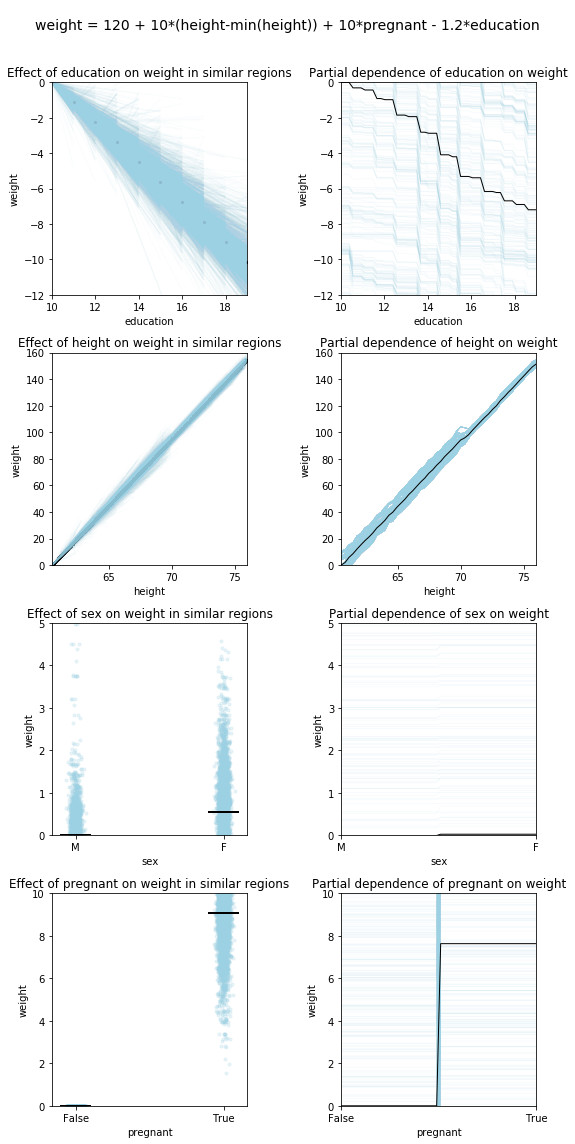

In [13]:
df_raw = toy_weight_data(2000)
df = df_raw.copy()
catencoders = df_string_to_cat(df)
df_cat_to_catcode(df)
df['pregnant'] = df['pregnant'].astype(int)
X = df.drop('weight', axis=1)
y = df['weight']

fig, axes = plt.subplots(5, 2, figsize=(8,16), gridspec_kw = {'height_ratios':[.2,3,3,3,3]})

axes[0,0].get_xaxis().set_visible(False)
axes[0,1].get_xaxis().set_visible(False)
axes[0,0].axis('off')
axes[0,1].axis('off')

mine_plot(X, y, 'education', 'weight', ax=axes[1][0],
             yrange=(-12,0)
             )
mine_plot(X, y, 'height', 'weight', ax=axes[2][0],
             yrange=(0,160)
             )
mine_catplot(X, y, 'sex', 'weight', ax=axes[3][0], ntrees=50,
                 alpha=.2,
                 cats=df_raw['sex'].unique(),
                 yrange=(0,5)
                 )
mine_catplot(X, y, 'pregnant', 'weight', ax=axes[4][0], ntrees=50,
                 alpha=.2,
                 cats=df_raw['pregnant'].unique(),
                 yrange=(0,10)
                 )

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)

if True:
    ice = ice_predict(rf, X, 'education', 'weight')
    ice_plot(ice, 'education', 'weight', ax=axes[1, 1], yrange=(-12, 0))
    ice = ice_predict(rf, X, 'height', 'weight')
    ice_plot(ice, 'height', 'weight', ax=axes[2, 1], yrange=(0, 160))
    ice = ice_predict(rf, X, 'sex', 'weight')
    ice_plot(ice, 'sex', 'weight', ax=axes[3,1], yrange=(0,5), cats=df_raw['sex'].unique())
    ice = ice_predict(rf, X, 'pregnant', 'weight')
    ice_plot(ice, 'pregnant', 'weight', ax=axes[4,1], yrange=(0,10), cats=df_raw['pregnant'].unique())

fig.suptitle("weight = 120 + 10*(height-min(height)) + 10*pregnant - 1.2*education", size=14)

plt.tight_layout()

# Reproduce variable interaction "big X" data from ICE paper

Peeking Inside the Black Box: Visualizing Statistical Learning with Plots of Individual Conditional Expectation by Alex Goldstein, Adam Kapelner†, Justin Bleich‡, and Emil Pitkin. https://arxiv.org/abs/1309.6392#

In [14]:
def bigX_data(n):
    x1 = np.random.uniform(-1, 1, size=n)
    x2 = np.random.uniform(-1, 1, size=n)
    x3 = np.random.uniform(-1, 1, size=n)

    y = 0.2 * x1 - 5 * x2 + 10 * x2 * np.where(x3 >= 0, 1, 0) + np.random.normal(0, 1, size=n)
    df = pd.DataFrame()
    df['x1'] = x1
    df['x2'] = x2
    df['x3'] = x3
    df['y'] = y
    return df

collect_leaf_slopes 5.537s
collect_leaf_slopes 5.685s
collect_leaf_slopes 5.747s
RF OOB 0.8677570230634203
ICE_predict 0.136s
ICE_predict 0.102s
ICE_predict 0.122s


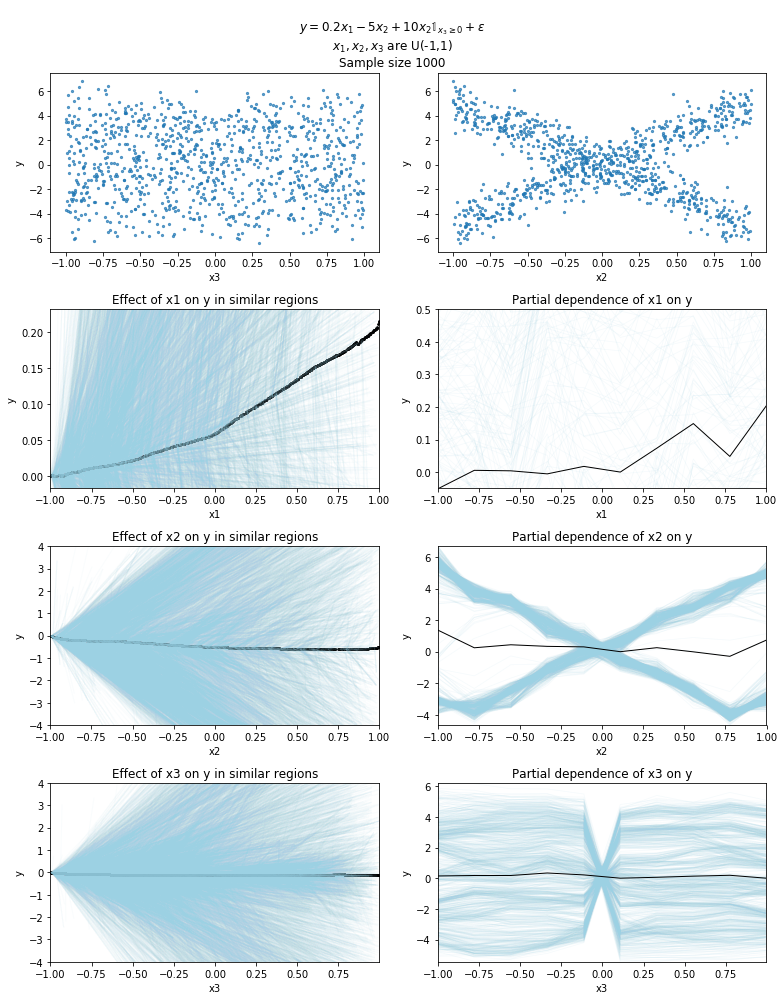

In [18]:
n = 1000
df = bigX_data(n=n)
X = df.drop('y', axis=1)
y = df['y']

fig, axes = plt.subplots(5, 2, figsize=(11, 14), gridspec_kw = {'height_ratios':[.1,4,4,4,4]})

axes[0, 0].get_xaxis().set_visible(False)
axes[0, 1].get_xaxis().set_visible(False)
axes[0, 0].axis('off')
axes[0, 1].axis('off')

axes[1,0].scatter(df['x3'], y, s=5, alpha=.7)
axes[1,0].set_xlabel('x3')
axes[1,0].set_ylabel('y')

axes[1,1].scatter(df['x2'], df['y'], s=5, alpha=.7)
axes[1,1].set_ylabel('y')
axes[1,1].set_xlabel('x2')

# Partial deriv is just 0.2 so this is correct. flat deriv curve, net effect line at slope .2
# ICE is way too shallow and not line at n=1000 even
mine_plot(X, y, 'x1', 'y', ax=axes[2,0])
# Partial deriv wrt x2 is -5 plus 10 about half the time so about 0
# Should not expect a criss-cross like ICE since deriv of 1_x3>=0 is 0 everywhere
# wrt to any x, even x3. x2 *is* affecting y BUT the net effect at any spot
# is what we care about and that's 0. Just because marginal x2 vs y shows non-
# random plot doesn't mean that x2's net effect is nonzero. We are trying to
# strip away x1/x3's effect upon y. When we do, x2 has no effect on y.
# Key is asking right question. Don't look at marginal plot and say obvious.
# Ask what is net effect at every x2? 0.
mine_plot(X, y, 'x2', 'y', ax=axes[3,0], yrange=(-4,4))
# Partial deriv wrt x3 of 1_x3>=0 is 0 everywhere so result must be 0
mine_plot(X, y, 'x3', 'y', ax=axes[4,0], yrange=(-4,4))

rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
rf.fit(X, y)
print(f"RF OOB {rf.oob_score_}")

ice = ice_predict(rf, X, 'x1', 'y', numx=10)
ice_plot(ice, 'x1', 'y', ax=axes[2, 1], yrange=(-.05,.5))

ice = ice_predict(rf, X, 'x2', 'y', numx=10)
ice_plot(ice, 'x2', 'y', ax=axes[3, 1])

ice = ice_predict(rf, X, 'x3', 'y', numx=10)
ice_plot(ice, 'x3', 'y', ax=axes[4, 1])

fig.suptitle("$y = 0.2x_1 - 5x_2 + 10x_2\mathbb{1}_{x_3 \geq 0} + \epsilon$\n$x_1, x_2, x_3$ are U(-1,1)\nSample size "+str(n))
plt.tight_layout()
plt.show()

In [ ]:

def toy_x1_times_x2_data(n=100):
    df = pd.DataFrame()
    i = np.linspace(0, 10, num=n)
    df['x1'] = np.random.uniform(0, 1, size=n)
    df['x2'] = np.random.uniform(0, 1, size=n)
    df['y'] = df['x1'] * df['x2']# + df['x1'] + df['x2']
    return df, f"y = x1x2\nx1, x2 in U(0,1)", (0,.6)


def toy_2x1_times_3x2_data(n=100):
    df = pd.DataFrame()
    i = np.linspace(0, 10, num=n)
    df['x1'] = np.random.uniform(0, 1, size=n)
    df['x2'] = np.random.uniform(0, 1, size=n)
    df['y'] = 2*df['x1'] * 3*df['x2']# + df['x1'] + df['x2']
    return df, f"y = 2x1 * 3x2\nx1, x2 in U(0,1)", (0,4)





def toy_weather_data():
    def temp(x): return np.sin((x+365/2)*(2*np.pi)/365)
    def noise(state): return np.random.normal(-5, 5, sum(df['state'] == state))

    df = pd.DataFrame()
    df['dayofyear'] = range(1,365+1)
    df['state'] = np.random.choice(['CA','CO','AZ','WA'], len(df))
    df['temperature'] = temp(df['dayofyear'])
    df.loc[df['state']=='CA','temperature'] = 70 + df.loc[df['state']=='CA','temperature'] * noise('CA')
    df.loc[df['state']=='CO','temperature'] = 40 + df.loc[df['state']=='CO','temperature'] * noise('CO')
    df.loc[df['state']=='AZ','temperature'] = 90 + df.loc[df['state']=='AZ','temperature'] * noise('AZ')
    df.loc[df['state']=='WA','temperature'] = 60 + df.loc[df['state']=='WA','temperature'] * noise('WA')
    return df



def weather():
    df_raw = toy_weather_data()
    df = df_raw.copy()
    catencoders = df_string_to_cat(df)
    print(catencoders)
    df_cat_to_catcode(df)
    X = df.drop('temperature', axis=1)
    y = df['temperature']

    fig, axes = plt.subplots(4, 2, figsize=(8,8), gridspec_kw = {'height_ratios':[.2,3,3,3]})

    axes[0,0].get_xaxis().set_visible(False)
    axes[0,1].get_xaxis().set_visible(False)
    axes[0,0].axis('off')
    axes[0,1].axis('off')

    """
    The scale diff between states, obscures the sinusoidal nature of the
    dayofyear vs temp plot. With noise N(0,5) gotta zoom in -3,3 on mine too.
    otherwise, smooth quasilinear plot with lots of bristles showing volatility.
    Flip to N(-5,5) which is more realistic and we see sinusoid for both, even at
    scale. yep, the N(0,5) was obscuring sine for both. 
    """
    partial_plot(X, y, 'dayofyear', 'temperature', ax=axes[1][0],
                 ntrees=50, min_samples_leaf=2, yrange=(-5,5))
    cat_partial_plot(X, y, 'state', 'temperature', cats=catencoders['state'], ax=axes[2][0])#, yrange=(0,160))

    rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=1, oob_score=True)
    rf.fit(X, y)

    ice = ICE_predict(rf, X, 'dayofyear', 'temperature')
    plot_ICE(ice, 'dayofyear', 'temperature', ax=axes[1, 1])  #, yrange=(-12,0))

    ice = ICE_predict(rf, X, 'state', 'temperature')
    plot_ICE(ice, 'state', 'temperature', cats=catencoders['state'], ax=axes[2, 1])  #, yrange=(-12,0))

    df = df_raw.copy()
    axes[3, 0].plot(df.loc[df['state'] == 'CA', 'dayofyear'],
             df.loc[df['state'] == 'CA', 'temperature'], label="CA")
    axes[3, 0].plot(df.loc[df['state'] == 'CO', 'dayofyear'],
             df.loc[df['state'] == 'CO', 'temperature'], label="CO")
    axes[3, 0].plot(df.loc[df['state'] == 'AZ', 'dayofyear'],
             df.loc[df['state'] == 'AZ', 'temperature'], label="AZ")
    axes[3, 0].plot(df.loc[df['state'] == 'WA', 'dayofyear'],
             df.loc[df['state'] == 'WA', 'temperature'], label="WA")
    axes[3, 0].legend()
    axes[3,0].set_title('Raw data')
    axes[3, 0].set_ylabel('Temperature')
    axes[3, 0].set_xlabel('Dataframe row index')

    rtreeviz_univar(axes[3,1],
                    X['state'], y,
                    feature_name='state',
                    target_name='y',
                    min_samples_leaf=2,
                    fontsize=10)
    axes[3,1].set_title(f'state space partition with min_samples_leaf={2}')
    axes[3,1].set_xlabel("state")
    axes[3,1].set_ylabel("y")

    plt.tight_layout()

    plt.savefig("/tmp/weather.svg")
    plt.show()

def interaction(f, n=100):
    df,eqn,yrange = f(n=n)

    X = df.drop('y', axis=1)
    y = df['y']
    min_samples_leaf = 2

    fig, axes = plt.subplots(4, 2, figsize=(10,13))

    axes[0,0].plot(range(len(df)), df['x1'], label="x1")
    axes[0,0].plot(range(len(df)), df['x2'], label="x2")
    axes[0,0].plot(range(len(df)), df['y'], label="y")
    axes[0, 0].set_xlabel("df row index")
    axes[0, 0].set_ylabel("df value")
    axes[0, 0].legend()
    axes[0, 0].set_title(f"Raw data; {eqn}")

    # axes[0,1].get_xaxis().set_visible(False)
    # axes[0,1].axis('off')

    rtreeviz_univar(axes[0,1],
                    df['x1'], y,
                    feature_name='x1',
                    target_name='y',
                    min_samples_leaf=min_samples_leaf,
                    fontsize=10)
    axes[0,1].set_title(f'x1 space partition with min_samples_leaf={min_samples_leaf}')
    axes[0,1].set_xlabel("x1")
    axes[0,1].set_ylabel("y")

    # print(df)
    # print(f"x1 = {df['x1'].values.tolist()}")
    # print(f"x2 = {df['x2'].values.tolist()}")
    # print(f"y = {df['y'].values.tolist()}")
    axes[1,0].scatter(df['x1'], y)
    axes[1,0].set_xlabel("x1")
    axes[1,0].set_ylabel("y")
    axes[1,1].scatter(df['x2'], y)
    axes[1,1].set_xlabel("x2")
    axes[1,1].set_ylabel("y")

    partial_plot(X, y, 'x1', 'y', ax=axes[2][0],
                 ntrees=30, min_samples_leaf=min_samples_leaf, yrange=yrange,
                 show_derivative=True)
    # partial_plot(X, y, 'education', 'weight', ntrees=20, min_samples_leaf=7, alpha=.2)
    partial_plot(X, y, 'x2', 'y', ax=axes[3][0], min_samples_leaf=min_samples_leaf,
                 ntrees=30, yrange=yrange,
                 show_derivative=True)
    # cat_partial_plot(axes[2][0], X, y, 'sex', 'weight', ntrees=50, min_samples_leaf=7, cats=df_raw['sex'].unique(), yrange=(0,2))
    # cat_partial_plot(axes[3][0], X, y, 'pregnant', 'weight', ntrees=50, min_samples_leaf=7, cats=df_raw['pregnant'].unique(), yrange=(0,10))

    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
    rf.fit(X, y)

    ice = ICE_predict(rf, X, 'x1', 'y', numx=None)
    plot_ICE(ice, 'x1', 'y', ax=axes[2, 1], yrange=yrange)
    ice = ICE_predict(rf, X, 'x2', 'y', numx=None)
    plot_ICE(ice, 'x2', 'y', ax=axes[3, 1], yrange=yrange)

    plt.tight_layout()

    plt.savefig(f"/tmp/interaction-{n}.png")
    plt.show()


def wine():
    wine = load_wine()


def bigX():
    def bigX_data(n):
        x1 = np.random.uniform(-1, 1, size=n)
        x2 = np.random.uniform(-1, 1, size=n)
        x3 = np.random.uniform(-1, 1, size=n)

        y = 0.2 * x1 - 5 * x2 + 10 * x2 * np.where(x3 >= 0, 1, 0) + np.random.normal(0, 1, size=n)
        df = pd.DataFrame()
        df['x1'] = x1
        df['x2'] = x2
        df['x3'] = x3
        df['y'] = y
        return df

    n = 1000
    df = bigX_data(n=n)
    X = df.drop('y', axis=1)
    y = df['y']

    fig, axes = plt.subplots(5, 2, figsize=(11, 14), gridspec_kw = {'height_ratios':[.1,4,4,4,4]})

    axes[0, 0].get_xaxis().set_visible(False)
    axes[0, 1].get_xaxis().set_visible(False)
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')

    axes[1,0].scatter(df['x3'], y, s=5, alpha=.7)
    axes[1,0].set_xlabel('x3')
    axes[1,0].set_ylabel('y')

    axes[1,1].scatter(df['x2'], df['y'], s=5, alpha=.7)
    axes[1,1].set_ylabel('y')
    axes[1,1].set_xlabel('x2')

    # Partial deriv is just 0.2 so this is correct. flat deriv curve, net effect line at slope .2
    # ICE is way too shallow and not line at n=1000 even
    partial_plot(X, y, 'x1', 'y', ax=axes[2,0])
    # Partial deriv wrt x2 is -5 plus 10 about half the time so about 0
    # Should not expect a criss-cross like ICE since deriv of 1_x3>=0 is 0 everywhere
    # wrt to any x, even x3. x2 *is* affecting y BUT the net effect at any spot
    # is what we care about and that's 0. Just because marginal x2 vs y shows non-
    # random plot doesn't mean that x2's net effect is nonzero. We are trying to
    # strip away x1/x3's effect upon y. When we do, x2 has no effect on y.
    # Key is asking right question. Don't look at marginal plot and say obvious.
    # Ask what is net effect at every x2? 0.
    partial_plot(X, y, 'x2', 'y', ax=axes[3,0], yrange=(-4,4))
    # Partial deriv wrt x3 of 1_x3>=0 is 0 everywhere so result must be 0
    partial_plot(X, y, 'x3', 'y', ax=axes[4,0], yrange=(-4,4))

    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
    rf.fit(X, y)
    print(f"RF OOB {rf.oob_score_}")

    ice = ICE_predict(rf, X, 'x1', 'y', numx=10)
    plot_ICE(ice, 'x1', 'y', ax=axes[2, 1], yrange=(-.05,.5))

    ice = ICE_predict(rf, X, 'x2', 'y', numx=10)
    plot_ICE(ice, 'x2', 'y', ax=axes[3, 1])

    ice = ICE_predict(rf, X, 'x3', 'y', numx=10)
    plot_ICE(ice, 'x3', 'y', ax=axes[4, 1])

    fig.suptitle("$y = 0.2x_1 - 5x_2 + 10x_2\mathbb{1}_{x_3 \geq 0} + \epsilon$\n$x_1, x_2, x_3$ are U(-1,1)\nSample size "+str(n))
    plt.tight_layout()
    plt.show()


def boston():
    df = pd.read_csv('/Users/parrt/github/random-forest-importances/notebooks/data/boston.csv')
    X = df.drop('medv', axis=1)
    y = df['medv']

    """
    Wow. My net effect plots look kinda like the centered ICE c-ICE plots
    from paper: https://arxiv.org/pdf/1309.6392.pdf
    Mine are way smoother.
    """
    fig, axes = plt.subplots(3, 2, figsize=(8, 10), gridspec_kw = {'height_ratios':[.05,4,4]})

    axes[0, 0].get_xaxis().set_visible(False)
    axes[0, 1].get_xaxis().set_visible(False)
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')

    axes[1,0].scatter(df['age'], y, s=5, alpha=.7)
    axes[1,0].set_xlabel('age')
    axes[1,0].set_ylabel('median home value')

    partial_plot(X, y, 'age', 'medv', ax=axes[2,0], show_derivative=True, yrange=(-20,20))

    rf = RandomForestRegressor(n_estimators=100, oob_score=True)
    rf.fit(X, y)
    print(f"RF OOB {rf.oob_score_}")

    ice = ICE_predict(rf, X, 'age', 'medv', numx=10)
    plot_ICE(ice, 'age', 'medv', ax=axes[2, 1], yrange=(-20,20))

    fig.suptitle(f"Boston housing data {len(X)} training samples\nRandom Forest ntrees=100")
    plt.tight_layout()
    plt.show()


def additive_assessment():
    def data(n):
        x1 = np.random.uniform(-3, 3, size=n)
        x2 = np.random.uniform(-3, 3, size=n)
        x3 = np.random.uniform(-3, 3, size=n)
        x4 = np.random.uniform(-3, 3, size=n)

        y = x1*x1 + x2 + x3 + x4# + np.random.normal(0, 1, size=n)
        df = pd.DataFrame()
        df['x1'] = x1
        df['x2'] = x2
        df['x3'] = x3
        df['x4'] = x4
        df['y'] = y
        return df

    n = 500
    df = data(n=n)
    X = df.drop('y', axis=1)
    y = df['y']

    fig, axes = plt.subplots(4, 2, figsize=(11, 14), gridspec_kw = {'height_ratios':[.1,4,4,4]})

    axes[0, 0].get_xaxis().set_visible(False)
    axes[0, 0].axis('off')
    axes[0, 1].get_xaxis().set_visible(False)
    axes[0, 1].axis('off')

    # axes[1,0].scatter(df['x1'], y, s=5, alpha=.7)
    # axes[1,0].set_xlabel('x1')
    # axes[1,0].set_ylabel('y')

    """
    When we have too many samples in leaf, we don't get enough detail / points
    near zero and it looks like line not parabola.
    
    Mine looks like parabola but U(-3,3) gives max values of 2.5ish for -3 and 3
    whereas PDP gives 8 for -3 and 3. n=1000 seems a bit shifted but n=2000 gets
    center/base of parabola correctly at x1=0.
    
    When one is shallow like a line then leaf might get lots of values and
    therefore bad slope estimate. Just two vars like y=x1^2 + x2 shows us biased
    too low for x1. 
    
    oh shit. the RF is bootstrapping and missing lots of values. try all.
    Make max_features=1.0 too. we don't care about overfitting here, do we?
    
    Turning off bootstrap (no replace, but same sample size) gets much taller
    parabola, though max_features=1.0 didn't do much.
    """
    min_samples_leaf = 2
    rtreeviz_univar(axes[1,0],
                    df['x1'], y,
                    feature_name='x1',
                    target_name='y',
                    min_samples_leaf=min_samples_leaf,
                    fontsize=10)
    axes[1,0].set_title(f'x1 space partition with min_samples_leaf={min_samples_leaf}')
    axes[1,0].set_xlabel("x1")
    axes[1,0].set_ylabel("y")

    rtreeviz_univar(axes[1,1],
                    df['x2'], y,
                    feature_name='x2',
                    target_name='y',
                    min_samples_leaf=min_samples_leaf,
                    fontsize=10)
    axes[1,1].set_title(f'x2 space partition with min_samples_leaf={min_samples_leaf}')
    axes[1,1].set_xlabel("x2")
    axes[1,1].set_ylabel("y")

    partial_plot(X, y, 'x1', 'y', ax=axes[2,0], min_samples_leaf=min_samples_leaf)
    partial_plot(X, y, 'x2', 'y', ax=axes[3,0], min_samples_leaf=min_samples_leaf)

    rf = RandomForestRegressor(n_estimators=100, min_samples_leaf=1, oob_score=True)
    rf.fit(X, y)
    print(f"RF OOB {rf.oob_score_}")

    ice = ICE_predict(rf, X, 'x1', 'y', numx=20)
    plot_ICE(ice, 'x1', 'y', ax=axes[2, 1])

    ice = ICE_predict(rf, X, 'x2', 'y', numx=20)
    plot_ICE(ice, 'x2', 'y', ax=axes[3, 1], yrange=(-3,3))

    fig.suptitle("$y = x_1^2 + x_2 + x_3 + x_4$\n$x_1, x_2, x_3$ are U(-3,3)\nSample size "+str(n))
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    # cars()
    # rent()
    weight()
    # weather()
    # interaction(toy_x1_times_x2_data)
    # interaction(toy_2x1_times_3x2_data)
    # bigX()
    # boston()
    # additive_assessment()